In [1]:
import pandas as pd

from sklearn.preprocessing import LabelEncoder
import nltk

In [2]:
df = pd.read_csv('../dataset/spam.csv' , encoding='latin-1')

In [3]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
df.shape

(5572, 5)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [6]:
df.columns

Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

# Data Cleaning

In [7]:
df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'] , inplace=True)

In [8]:
df.rename(columns={'v1':'target' , 'v2':'text'} , inplace=True)

In [9]:
df['target'].unique()

array(['ham', 'spam'], dtype=object)

In [10]:
encoder = LabelEncoder()

df['target'] = encoder.fit_transform(df['target'])

In [11]:
df.head()

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [12]:
df.isnull().sum()

target    0
text      0
dtype: int64

In [13]:
df.duplicated().sum()

403

In [14]:
df = df.drop_duplicates(keep='first')

In [15]:
df.shape

(5169, 2)

# EDA

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
df['target'].value_counts()

0    4516
1     653
Name: target, dtype: int64

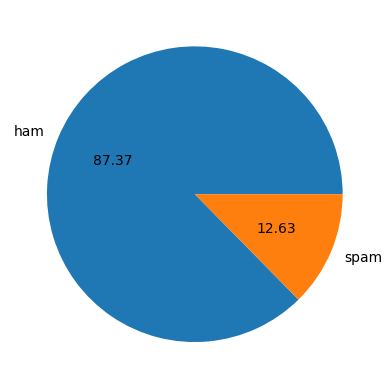

In [18]:
plt.pie(df['target'].value_counts() , labels=['ham' , 'spam']  , autopct="%0.2f")
plt.show()

spam is only 12% of the data hence data is imbalanced.

In [19]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\windows\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [20]:
# creating columns for number of characters words and sentence in each text
df['num_characters'] = df['text'].apply(lambda x : len(x))

In [21]:
df['num_words'] = df['text'].apply(lambda x:len( nltk.word_tokenize(x)))

In [22]:
df['num_sentence'] = df['text'].apply(lambda x :len( nltk.sent_tokenize(x)))

In [23]:
# for ham msgs
df[df['target'] == 0 ].describe()

,target,num_characters,num_words,num_sentence
count,4516.0,4516.000000,4516.000000,4516.000000
mean,0.0,70.459256,17.123782,1.820195
std,0.0,56.358207,13.493970,1.383657
min,0.0,2.000000,1.000000,1.000000
25%,0.0,34.000000,8.000000,1.000000
50%,0.0,52.000000,13.000000,1.000000
75%,0.0,90.000000,22.000000,2.000000
max,0.0,910.000000,220.000000,38.000000


In [24]:
df[df['target'] == 1 ].describe()

,target,num_characters,num_words,num_sentence
count,653.0,653.000000,653.000000,653.000000
mean,1.0,137.891271,27.667688,2.970904
std,0.0,30.137753,7.008418,1.488425
min,1.0,13.000000,2.000000,1.000000
25%,1.0,132.000000,25.000000,2.000000
50%,1.0,149.000000,29.000000,3.000000
75%,1.0,157.000000,32.000000,4.000000
max,1.0,224.000000,46.000000,9.000000


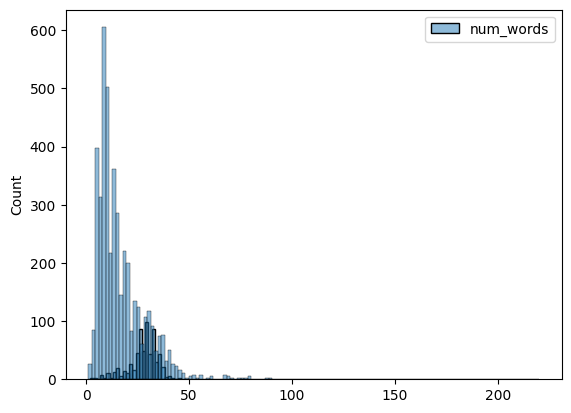

In [25]:
# plotting histogram for distribution

sns.histplot(df[df['target'] == 1][['num_words']] ) #spam msgs
sns.histplot(df[df['target'] == 0][['num_words']] , color = 'red' ) #ham msgs
plt.show()

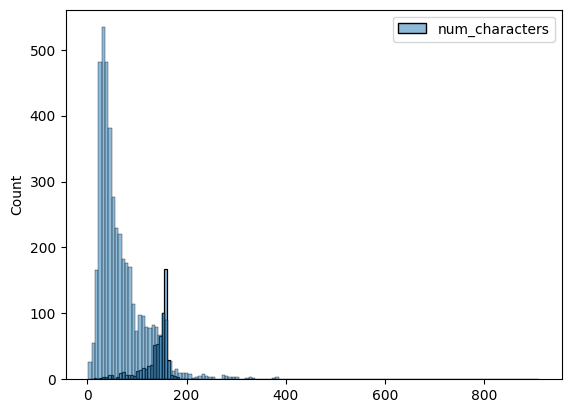

In [26]:
sns.histplot(df[df['target'] == 1][['num_characters']] ) #spam msgs
sns.histplot(df[df['target'] == 0][['num_characters']] , color = 'red' ) #ham msgs
plt.show()

C:\Users\windows\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


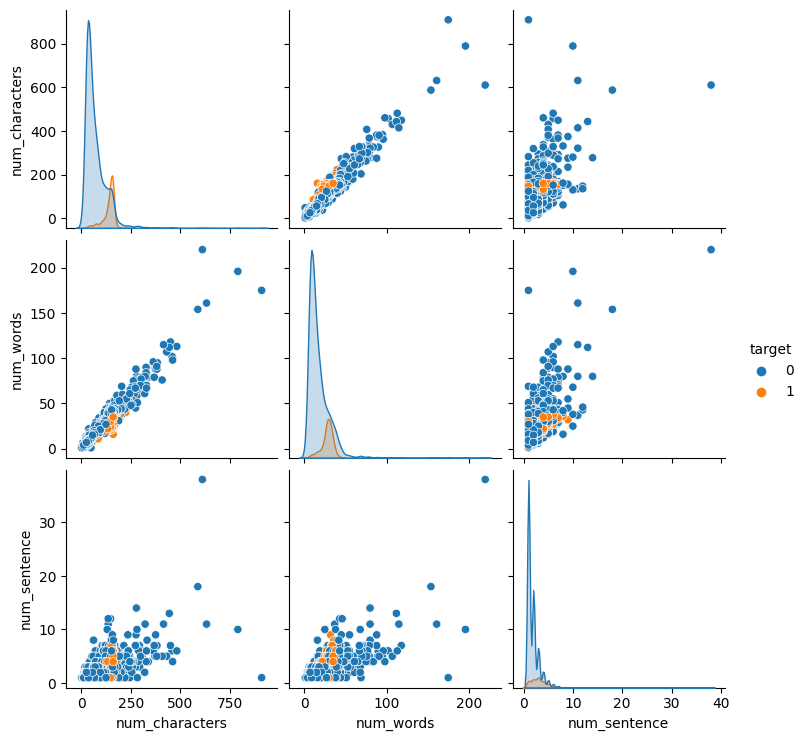

In [27]:
sns.pairplot(df , hue='target')
plt.show()

C:\Users\windows\AppData\Local\Temp\ipykernel_13196\1150832963.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr() , annot=True)


<Axes: >

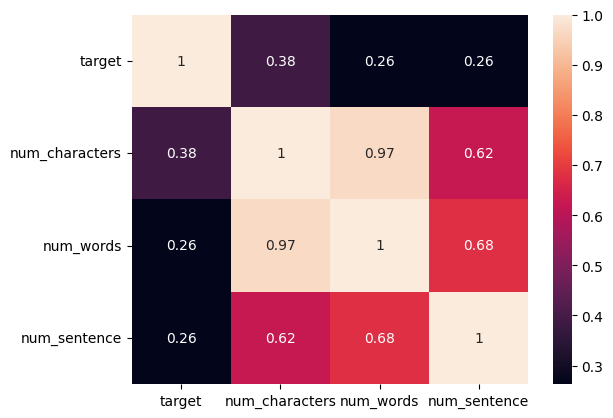

In [28]:
sns.heatmap(df.corr() , annot=True)

**num_char , num_word, num_sentence are strongly correlated to each** , so we cannot keep them all of the columns.
we will **keep num_char columns beacause it is strongly correlated to target column.**

## Data Preprocessing
- Lowercase
- Word Tokenize
- Removing Special Characters
- Removing Stop words and punctuation
- Stemming

In [29]:
import string
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from wordcloud import WordCloud
from collections import Counter

In [30]:
def text_transform(text):
    text = text.lower()
    text = nltk.word_tokenize(text)
    
    y = []
    
    # removing special chars
    for i in text:
        if i.isalnum():
            y.append(i)
    text = y[:]                 # cloning because the list is mutable so after clearing y text will be cleared
    
    y.clear()
    # removing punctuations and stopwords
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)
    text = y[:]
    y.clear()
    #stemming
    ps = PorterStemmer()
    for i in text:
        y.append(ps.stem(i))
    
    return " ".join(y) # return the list in the form of string


In [31]:
df['transformed_text'] = df['text'].apply(text_transform)

In [32]:
# creating a word cloud to check which words are common in spam msgs and ham msgs
wc = WordCloud(height=500 , width=500 , background_color='white')

In [33]:
spam_wc = wc.generate(df[df['target'] == 1]['transformed_text'].str.cat(sep=" "))

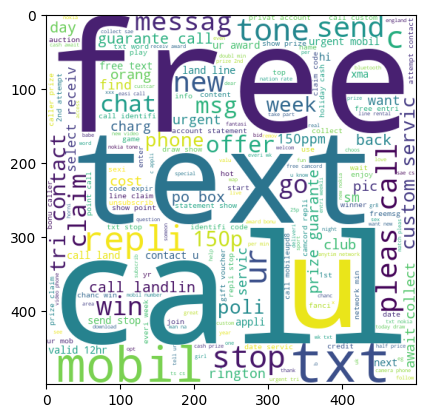

In [34]:
plt.imshow(spam_wc)

In [35]:
ham_wc = wc.generate(df[df['target'] == 0]['transformed_text'].str.cat(sep=" "))

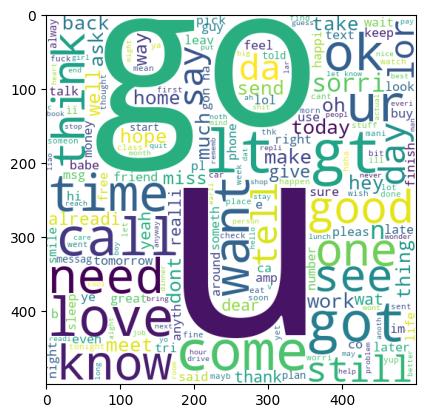

In [36]:
plt.imshow(spam_wc)

In [37]:
# Top 30 words in spam 
spam_corpus = []
for msg in df[df['target'] == 1]['transformed_text']:
    for word in msg.split():
        spam_corpus.append(word)

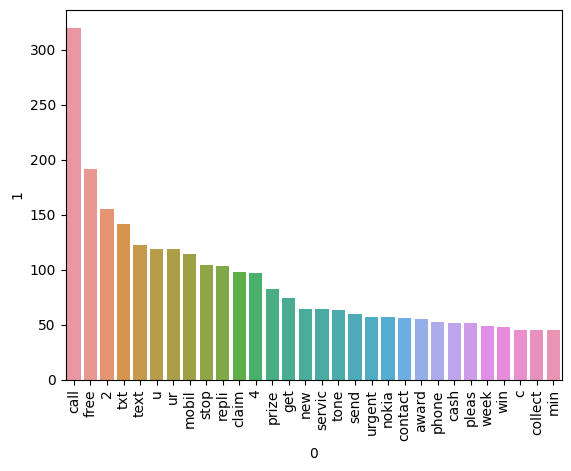

In [38]:
sns.barplot(x = pd.DataFrame(Counter(spam_corpus).most_common(30))[0] , y = pd.DataFrame(Counter(spam_corpus).most_common(30))[1])
plt.xticks(rotation = 90)
plt.show()

# Model Building

In [55]:
from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import GaussianNB , BernoulliNB , MultinomialNB
from sklearn.metrics import accuracy_score , precision_score , confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

In [56]:
tf = TfidfVectorizer(max_features=3000)

In [57]:
cv = CountVectorizer()

In [58]:
X = tf.fit_transform(df['transformed_text']).toarray()

In [59]:
y = df['target'].values

In [60]:
X.shape , y.shape

((5169, 3000), (5169,))

In [61]:
X_train , X_test , y_train , y_test = train_test_split(X , y , test_size=0.2 , random_state=23)

In [62]:
svc = SVC(kernel='sigmoid', gamma=1.0)
mnb = MultinomialNB()
dtc = DecisionTreeClassifier(max_depth=5)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
bc = BaggingClassifier(n_estimators=50, random_state=2)
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
gbdt = GradientBoostingClassifier(n_estimators=50,random_state=2)
xgb = XGBClassifier(n_estimators=50,random_state=2)

In [63]:
clfs = {
    'SVC' : svc,
#     'KN' : knc, 
    'NB': mnb, 
    'DT': dtc, 
    'LR': lrc, 
    'RF': rfc, 
    'AdaBoost': abc, 
    'BgC': bc, 
    'ETC': etc,
    'GBDT':gbdt,
    'xgb':xgb
}

In [64]:
def train_classifier(clf,X_train,y_train,X_test,y_test):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    
    return accuracy,precision

In [65]:
train_classifier(mnb,X_train,y_train,X_test,y_test)


(0.9816247582205029, 1.0)

In [66]:
accuracy_scores = []
precision_scores = []

for name,clf in clfs.items():
    
    current_accuracy,current_precision = train_classifier(clf, X_train,y_train,X_test,y_test)
    
    print("For ",name)
    print("Accuracy - ",current_accuracy)
    print("Precision - ",current_precision)
    
    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)

For  SVC
Accuracy -  0.9758220502901354
Precision -  0.9514563106796117
For  NB
Accuracy -  0.9816247582205029
Precision -  1.0
For  DT
Accuracy -  0.9429400386847195
Precision -  0.797979797979798
For  LR
Accuracy -  0.9564796905222437
Precision -  0.8924731182795699
For  RF
Accuracy -  0.9816247582205029
Precision -  1.0
For  AdaBoost
Accuracy -  0.9632495164410058
Precision -  0.8773584905660378
For  BgC
Accuracy -  0.9632495164410058
Precision -  0.8448275862068966
For  ETC
Accuracy -  0.9835589941972921
Precision -  0.9719626168224299
For  GBDT
Accuracy -  0.9632495164410058
Precision -  0.9545454545454546
For  xgb
Accuracy -  0.9738878143133463
Precision -  0.9333333333333333


In [67]:
score_df = pd.DataFrame({'Classifier':clfs.keys() , 'Accuracy':accuracy_scores , 'Precision':precision_scores})
score_df.sort_values(by ='Precision' , ascending=False )

,Classifier,Accuracy,Precision
1,NB,0.981625,1.000000
4,RF,0.981625,1.000000
7,ETC,0.983559,0.971963
8,GBDT,0.963250,0.954545
0,SVC,0.975822,0.951456
9,xgb,0.973888,0.933333
3,LR,0.956480,0.892473
5,AdaBoost,0.963250,0.877358
6,BgC,0.963250,0.844828
2,DT,0.942940,0.797980


In [70]:
import pickle

pickle.dump( tf, open('../vectorizer.pkl' , 'wb'))
pickle.dump(mnb , open('../model.pkl' , 'wb'))